### Chain Using LangGraph

In this section we will see how we can build a simple chain using LangGraph that uses 4 important concepts.

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to build tools to our LLM in chat models
- How to execute the tools call in our graph nodes

In [138]:
from dotenv import load_dotenv
load_dotenv()

True

### How to use chat messages as our graph state

#### Messages

We can use messages which can be used to capture different roles within a conversation. LangChain has various messages types including HumanMessages, AIMessages, SystemMessages and ToolMessages. These represent a messages from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.
- content - content of the message
- name - specify the name of the author
- response_metadata - optionally, a dict of metadata

In [139]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

messages=[
    AIMessage(
        content=f"Please tell me how can i help you",
        name='LLMmodel'
    )
]
messages.append(
    HumanMessage(
        content=f"I want to learn coding",
          name='Rahul') # type: ignore
)
messages.append(
    AIMessage(
        content=f"which programming language you want to learn?",
        name='LLMmodel'
    )
)
messages.append(
    HumanMessage(
        content=f"I want to python give me roadmap",
          name='Rahul') # type: ignore
)



In [140]:
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMmodel

Please tell me how can i help you
================================ Human Message =================================
Name: Rahul

I want to learn coding
================================== Ai Message ==================================
Name: LLMmodel

which programming language you want to learn?
================================ Human Message =================================
Name: Rahul

I want to python give me roadmap


### Chat Models
We can use the sequence of messages as input with the chatModels using LLM's and OPENAI.



In [141]:
from langchain_groq import ChatGroq

llm = ChatGroq(model='llama-3.1-8b-instant')
result = llm.invoke(messages)
messages.append(
    AIMessage(content=result.content)
)

In [142]:
result.content

"Here's a step-by-step Python programming roadmap to help you get started:\n\n**Phase 1: Basics (1-2 weeks)**\n\n1. **Install Python**:\n\t* Download and install Python from the official website ([www.python.org](http://www.python.org)).\n\t* Choose the correct version (Python 3.x) and install it on your system.\n2. **Basic syntax and data types**:\n\t* Learn basic syntax, variables, data types, operators, and control structures (if-else, for loops, while loops).\n\t* Understand how to print output, use comments, and format text.\n3. **Basic data structures**:\n\t* Learn about lists, tuples, dictionaries, and sets.\n\t* Understand how to create, access, and manipulate these data structures.\n\n**Phase 2: Fundamental Programming Concepts (2-4 weeks)**\n\n1. **Functions**:\n\t* Learn how to define and use functions in Python.\n\t* Understand function arguments, return types, and scope.\n2. **Modules and packages**:\n\t* Learn how to import and use external libraries and modules.\n\t* Und

### Tools
Tools can be integrated with the LLM models to interact with external systems.<br>
External systems can be API's, third party tools.<br>
whenever a query is asked the model can choose to call the tool and this query is based on the natural language input and this will return an output that matches the tool's schema

In [143]:
def add(a:int,b:int)-> int:
    """ Add two numbers. Only use this tool if the user asks for addition or math operations.
    args:
        a(int): first int
        b(int): second int
    returns:
        int

    """
    print("add tool is called")
    return a+b


In [144]:
### Binding tool with llm
llm_with_tools =llm.bind_tools(
    [add]
)


In [145]:
tool_call=llm_with_tools.invoke(
    [
        HumanMessage(
            content='what is 2 + 5'
        )
    ]
)

In [146]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 5},
  'id': 'hfayx479y',
  'type': 'tool_call'}]

In [147]:
llm_with_tools.invoke("hi")

AIMessage(content='Hello. Is there something I can help you with?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 286, 'total_tokens': 298, 'completion_time': 0.027361394, 'prompt_time': 0.01687401, 'queue_time': 0.05166077000000001, 'total_time': 0.044235404}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'finish_reason': 'stop', 'logprobs': None}, id='run--31260525-60af-4f5f-89ba-1d6b590743e4-0', usage_metadata={'input_tokens': 286, 'output_tokens': 12, 'total_tokens': 298})

### Using messages as state

In [148]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    message:list[AnyMessage]

### Reducers
Now, we have a minor problem!<br>
As we discussed, each node will return a new value for our state key messages<br>
But, this new value will override the prior messages value.<br>
As our graph runs, we want to append messages to our message state key.<br>
we can use reducer function to address this.<br>
Reducers allow us to specify how state updates are performed.<br>
If no reducer is specified it will assumed the updates to the key should override it as we saw before.<br>
But to append that any messages we can use pre-built add_messages reducer.<br>
This ensures that any messages are appended to the existing list of messages.<br>
We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [149]:
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]
    


In [150]:
### Reducers with add_messages

initial_messages =[
    AIMessage(
        content=f"Please tell me how can i help you",
        name='LLMmodel'
    ),

    HumanMessage(
        content=f"I want to learn coding",
          name='Rahul') # type: ignore

]

In [151]:
initial_messages

[AIMessage(content='Please tell me how can i help you', additional_kwargs={}, response_metadata={}, name='LLMmodel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Rahul')]

In [152]:
ai_message=AIMessage(
        content=f"which programming language you want to learn?",
        name='LLMmodel'
    )

In [153]:
# Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can i help you', additional_kwargs={}, response_metadata={}, name='LLMmodel', id='cba878fd-8aef-4922-a5fa-993d232c6d96'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Rahul', id='70cee226-e941-4d97-8fe7-36e4d9b3dd17'),
 AIMessage(content='which programming language you want to learn?', additional_kwargs={}, response_metadata={}, name='LLMmodel', id='70bed8e4-c55a-4321-a14f-e0e2f42b1c2f')]

In [154]:
# chatbot node fun
def llm_tool(state:State):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

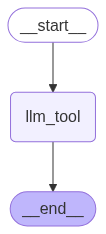

In [155]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START,END
builder = StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,'llm_tool')
builder.add_edge('llm_tool',END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [156]:
## invocation

messages = graph.invoke({"messages":"what is 5 plus 2"})
messages



{'messages': [HumanMessage(content='what is 5 plus 2', additional_kwargs={}, response_metadata={}, id='b761da24-868a-445d-ab59-7e076408d428'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7g5zrbkkb', 'function': {'arguments': '{"a":5,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 292, 'total_tokens': 310, 'completion_time': 0.032639284, 'prompt_time': 0.017230393, 'queue_time': 0.048513894, 'total_time': 0.049869677}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8ab2e50475', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e68eeec4-e120-457a-92de-4af2ee782111-0', tool_calls=[{'name': 'add', 'args': {'a': 5, 'b': 2}, 'id': '7g5zrbkkb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 292, 'output_tokens': 18, 'total_tokens': 310})]}

In [157]:
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

what is 5 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (7g5zrbkkb)
 Call ID: 7g5zrbkkb
  Args:
    a: 5
    b: 2


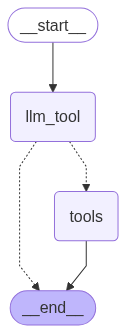

In [158]:
from langgraph.prebuilt import ToolNode, tools_condition

from IPython.display import Image, display
from langgraph.graph import StateGraph, START,END
builder = StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_node('tools',ToolNode([add]))

builder.add_edge(START,'llm_tool')
builder.add_conditional_edges(
    'llm_tool',
    # if the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # if the latest messages (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge('tools', END)


graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))




In [159]:
messages = graph.invoke({"messages":"what is 5 plus 2"})

for message in messages['messages']:
    message.pretty_print()

add tool is called
================================ Human Message =================================

what is 5 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (y2y1ftkfr)
 Call ID: y2y1ftkfr
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: add

7


In [160]:
messages = graph.invoke({"messages":"what is Machine learning?"})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

what is Machine learning?
================================== Ai Message ==================================

Machine learning is a field of study that gives computers the ability to learn without being explicitly programmed. It involves the use of algorithms and statistical models to enable machines to perform a specific task, such as image recognition, speech recognition, or decision-making, based on data they have been trained on.


In [161]:
graph.invoke({"messages":"hi"})


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='0f2587d7-6357-4249-8b2d-b198a0e9a7fb'),
  AIMessage(content='Hello. What can I help you with today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 286, 'total_tokens': 297, 'completion_time': 0.026118357, 'prompt_time': 0.016899699, 'queue_time': 0.051730521, 'total_time': 0.043018056}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'finish_reason': 'stop', 'logprobs': None}, id='run--d40c9880-2e17-4d10-8a6d-1ef75a6016e4-0', usage_metadata={'input_tokens': 286, 'output_tokens': 11, 'total_tokens': 297})]}